## Вычислительный эксперимент (базовый вариант)
### Предобработка данных

In [ ]:
# !pip install topicnet
# !pip install pymorphy3

In [81]:
import artm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set(style="darkgrid", palette="Set2")

from topicnet.dataset_manager import api

# topicnet imports
from topicnet.cooking_machine.cubes import (
    CubeCreator,
    GreedyStrategy,
    PerplexityStrategy,
    RegularizationControllerCube,
    RegularizersModifierCube,
)
from topicnet.cooking_machine.dataset import Dataset
from topicnet.cooking_machine.experiment import Experiment
from topicnet.cooking_machine.models import BaseScore
from topicnet.cooking_machine.models.topic_model import TopicModel
from topicnet.cooking_machine.model_constructor import add_standard_scores
from topicnet.cooking_machine.model_constructor import init_simple_default_model
from topicnet.cooking_machine.pretty_output import make_notebook_pretty
from topicnet.viewers.top_documents_viewer import TopDocumentsViewer
from topicnet.viewers.top_tokens_viewer import TopTokensViewer

from IPython.display import display, display_html

# for preprocessing
import nltk

from nltk.collocations import (
    BigramAssocMeasures,
    BigramCollocationFinder,
)
from nltk.corpus import (
    stopwords,
    wordnet,
)

nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.stem import WordNetLemmatizer

from pymorphy3 import MorphAnalyzer

from collections import Counter

from tqdm import tqdm

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


В качестве коллекции текстов используются [новости](https://www.kaggle.com/datasets/yutkin/corpus-of-russian-news-articles-from-lenta), опубликованные на сайте Lenta.ru до 2019-го года. Загружаем её.

In [2]:
df_lenta = pd.read_csv("lenta-ru-news.csv")
df_lenta

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning:

Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.



,url,title,text,topic,tags,date
0,https://lenta.ru/news/1914/09/16/hungarnn/,1914. Русские войска вступили в пределы Венгрии,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека,Первая мировая,1914/09/16
1,https://lenta.ru/news/1914/09/16/lermontov/,1914. Празднование столетия М.Ю. Лермонтова от...,"Министерство народного просвещения, в виду про...",Библиотека,Первая мировая,1914/09/16
2,https://lenta.ru/news/1914/09/17/nesteroff/,1914. Das ist Nesteroff!,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека,Первая мировая,1914/09/17
3,https://lenta.ru/news/1914/09/17/bulldogn/,1914. Бульдог-гонец под Льежем,Фотограф-корреспондент Daily Mirror рассказыва...,Библиотека,Первая мировая,1914/09/17
4,https://lenta.ru/news/1914/09/18/zver/,1914. Под Люблином пойман швабский зверь,"Лица, приехавшие в Варшаву из Люблина, передаю...",Библиотека,Первая мировая,1914/09/18
...,...,...,...,...,...,...
800970,https://lenta.ru/news/2019/12/14/shnur/,Шнуров раскритиковал Гагарину на «Голосе»,Певец Сергей Шнуров раскритиковал свою коллегу...,NaN,ТВ и радио,2019/12/14
800971,https://lenta.ru/news/2019/12/14/dolg/,В России предложили изменить правила взыскания...,Министерство юстиции России предложило изменит...,NaN,Все,2019/12/14
800972,https://lenta.ru/news/2019/12/14/dark_euro/,В России назвали «черную дату» для Европы,Испытание США ранее запрещенной Договором о ли...,NaN,Политика,2019/12/14
800973,https://lenta.ru/news/2019/12/14/meteo/,Россиянам пообещали аномально теплую погоду,В ближайшие дни в европейской части России пог...,NaN,Общество,2019/12/14


Далее обработаем данные по дате публикации.

In [3]:
df_lenta.date = pd.to_datetime(df_lenta.date)
df_lenta.date

0        1914-09-16
1        1914-09-16
2        1914-09-17
3        1914-09-17
4        1914-09-18
            ...    
800970   2019-12-14
800971   2019-12-14
800972   2019-12-14
800973   2019-12-14
800974   2019-12-14
Name: date, Length: 800975, dtype: datetime64[ns]

Для базового эксперимента выделим небольшую часть из коллекции текстов. В данном случае эта часть будет соответствовать 1 кварталу 2002 года.

In [11]:
df_lenta_short = df_lenta[(df_lenta['date'].dt.year == 2002) & (df_lenta['date'].dt.quarter == 1)]
df_lenta_short

,url,title,text,topic,tags,date
41236,https://lenta.ru/news/2002/01/01/churches/,В Индонезии взорвали четыре церкви,Во вторник в столице индонезийской провинции Ц...,Россия,Все,2002-01-01
41237,https://lenta.ru/news/2002/01/01/donkey/,В Англии полиция прервала забег 30 ослов,Во вторник в Англии в графстве Суррей (Surrey)...,Из жизни,Все,2002-01-01
41238,https://lenta.ru/news/2002/01/01/cocktails/,Толпа басков атаковала банки и полицию,Во вторник утром в Испании в баскском городе Г...,Россия,Все,2002-01-01
41239,https://lenta.ru/news/2002/01/01/bomb/,Взрыв в Карачи: ранены девять человек,По крайней мере девять человек ранены в резуль...,Россия,Все,2002-01-01
41240,https://lenta.ru/news/2002/01/01/euro/,Маленький остров в Индийском океане первым пер...,В ночь на 1 января начинается наличное обращен...,Экономика,Все,2002-01-01
...,...,...,...,...,...,...
46723,https://lenta.ru/news/2002/03/31/grach/,Верховный Суд Украины опроверг сообщения СМИ о...,В субботу Верховный суд Украины опроверг распр...,Россия,Все,2002-03-31
46724,https://lenta.ru/news/2002/03/31/aeroflot/,"Из Москвы вылетел последний ""курящий"" рейс ""Аэ...","Авиакомпания ОАО ""Аэрофлот - Российские авиали...",Россия,Все,2002-03-31
46725,https://lenta.ru/news/2002/03/31/train/,В Испании столкнулись два пассажирских поезда,В субботу в Испании на выезде с вокзала города...,Мир,Все,2002-03-31
46726,https://lenta.ru/news/2002/03/31/time/,Россия перешла на летнее время: стрелки перево...,В ночь с субботы на воскресенье Россия перешла...,Россия,Все,2002-03-31


Оставляем нужные колонки.

In [14]:
df_lenta_raw = pd.DataFrame(df_lenta_short[['title',
                                            'text',
                                            'topic',
                                            'tags']]).rename(columns={'text': 'raw_text'})
df_lenta_raw

,title,raw_text,topic,tags
41236,В Индонезии взорвали четыре церкви,Во вторник в столице индонезийской провинции Ц...,Россия,Все
41237,В Англии полиция прервала забег 30 ослов,Во вторник в Англии в графстве Суррей (Surrey)...,Из жизни,Все
41238,Толпа басков атаковала банки и полицию,Во вторник утром в Испании в баскском городе Г...,Россия,Все
41239,Взрыв в Карачи: ранены девять человек,По крайней мере девять человек ранены в резуль...,Россия,Все
41240,Маленький остров в Индийском океане первым пер...,В ночь на 1 января начинается наличное обращен...,Экономика,Все
...,...,...,...,...
46723,Верховный Суд Украины опроверг сообщения СМИ о...,В субботу Верховный суд Украины опроверг распр...,Россия,Все
46724,"Из Москвы вылетел последний ""курящий"" рейс ""Аэ...","Авиакомпания ОАО ""Аэрофлот - Российские авиали...",Россия,Все
46725,В Испании столкнулись два пассажирских поезда,В субботу в Испании на выезде с вокзала города...,Мир,Все
46726,Россия перешла на летнее время: стрелки перево...,В ночь с субботы на воскресенье Россия перешла...,Россия,Все


Далее реализуем функции для предобработки данных, которые позволят преобразовать датасет в необходимый формат для TopicNet.

In [16]:
def vowpalize_sequence(sequence):
    '''
    Переводит последовательность в формат из Vowpal Wabbit.

    Аргумент:
    sequence - последовательность

    Возвращает:
    res - результат преобразования
    '''
    word_freq = Counter(sequence)
    del word_freq['']
    
    res = ''
    for word in word_freq:
        res += word + ":" + str(word_freq[word]) + ' '
  
    return res

def process_data(dataframe, vocab_size=16000):
    '''
    Отвечает за предобработку набора данных для
    дальнейшего использования в TopicNet.

    Аргумент:
    dataframe - данные, содержащие колонку raw_text
    vocab_size - размер словаря биграмм

    Результат:
    dataframe - предобработанные данные
    '''

    tokenized_text = []  # инициализируем список
    
    # разбиваем на токены
    for _, data in tqdm(dataframe.iterrows()):
        tokens = [token for token in nltk.wordpunct_tokenize(data.title.lower()) if len(token) > 1]
        tokens.extend([token for token in nltk.wordpunct_tokenize(data.raw_text.lower()) if len(token) > 1])
        tokenized_text.append(tokens)
    
    # запоминаем токенизацию
    dataframe['tokenized'] = tokenized_text

    # список стопслов
    stop = set(stopwords.words('russian'))

    # применяем лемматизацию, используем PyMorphy3
    lemmatized_text = []
    morph = MorphAnalyzer()
    
    # переводим в нормальную форму
    for text in tqdm(dataframe['tokenized'].values):
        lemmatized = [morph.parse(word)[0].normal_form for word in text]
        lemmatized = [word for word in lemmatized 
                      if word not in stop and word.isalpha()]
        lemmatized_text.append(lemmatized)
    
    dataframe['lemmatized'] = lemmatized_text

    # выбираем лучшие биграммы
    bigram_measures = BigramAssocMeasures()
    finder = BigramCollocationFinder.from_documents(dataframe['lemmatized'])
    finder.apply_freq_filter(5)
    set_dict = set(finder.nbest(bigram_measures.pmi, vocab_size))
    documents = dataframe['lemmatized']
    bigrams = []

    # добавляем биграммы
    for doc in tqdm(documents):
        entry = ['_'.join([word_first, word_second])
                 for word_first, word_second in zip(doc[:-1],doc[1:])
                 if (word_first, word_second) in set_dict]
        bigrams.append(entry)

    dataframe['bigram'] = bigrams
    
    # добавялем текст в формате из Vowpal Wabbit
    vw_text = []

    for index, data in tqdm(dataframe.iterrows()):
        vw_string = ''    
        doc_id = str(index)
        lemmatized = '@lemmatized ' + vowpalize_sequence(data.lemmatized)
        bigram = '@bigram ' + vowpalize_sequence(data.bigram)
        vw_string = ' |'.join([doc_id, lemmatized, bigram])
        vw_text.append(vw_string)

    dataframe['vw_text'] = vw_text

    return dataframe

Устанавливаем недостающие пакеты.

In [10]:
nltk.download('averaged_perceptron_tagger_ru')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger_ru to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_ru is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Обрабатываем данные.

In [17]:
df_lenta_vm = process_data(df_lenta_raw)
df_lenta_vm

5492it [00:01, 3262.15it/s]
100%|██████████| 5492/5492 [00:00<00:00, 20718.44it/s]
5492it [00:01, 4046.50it/s]


,title,raw_text,topic,tags,tokenized,lemmatized,bigram,vw_text
41236,В Индонезии взорвали четыре церкви,Во вторник в столице индонезийской провинции Ц...,Россия,Все,"[индонезии, взорвали, четыре, церкви, во, втор...","[индонезия, взорвать, четыре, церковь, вторник...","[взрывной_устройство, пока_удаться, всё_находи...",41236 |@lemmatized индонезия:1 взорвать:2 четы...
41237,В Англии полиция прервала забег 30 ослов,Во вторник в Англии в графстве Суррей (Surrey)...,Из жизни,Все,"[англии, полиция, прервала, забег, 30, ослов, ...","[англия, полиция, прервать, забег, осёл, вторн...",[полиция_найти],41237 |@lemmatized англия:2 полиция:2 прервать...
41238,Толпа басков атаковала банки и полицию,Во вторник утром в Испании в баскском городе Г...,Россия,Все,"[толпа, басков, атаковала, банки, полицию, во,...","[толпа, баск, атаковать, банк, полиция, вторни...","[вторник_утром, примерно_километр, прибыть_мес...",41238 |@lemmatized толпа:1 баск:1 атаковать:1 ...
41239,Взрыв в Карачи: ранены девять человек,По крайней мере девять человек ранены в резуль...,Россия,Все,"[взрыв, карачи, ранены, девять, человек, по, к...","[взрыв, карачи, ранить, девять, человек, крайн...","[девять_человек, крайний_мера, девять_человек,...",41239 |@lemmatized взрыв:2 карачи:3 ранить:2 д...
41240,Маленький остров в Индийском океане первым пер...,В ночь на 1 января начинается наличное обращен...,Экономика,Все,"[маленький, остров, индийском, океане, первым,...","[маленький, остров, индийский, океан, первый, ...","[ночь_январь, монета_евро, евро_сообщать, сооб...",41240 |@lemmatized маленький:2 остров:2 индийс...
...,...,...,...,...,...,...,...,...
46723,Верховный Суд Украины опроверг сообщения СМИ о...,В субботу Верховный суд Украины опроверг распр...,Россия,Все,"[верховный, суд, украины, опроверг, сообщения,...","[верховный, суд, украина, опровергнуть, сообще...","[верховный_суд, суд_украина, опровергнуть_сооб...",46723 |@lemmatized верховный:7 суд:11 украина:...
46724,"Из Москвы вылетел последний ""курящий"" рейс ""Аэ...","Авиакомпания ОАО ""Аэрофлот - Российские авиали...",Россия,Все,"[из, москвы, вылетел, последний, курящий, рейс...","[москва, вылететь, последний, курящий, рейс, а...","[рейс_аэрофлот, оао_аэрофлот, запрет_курение, ...",46724 |@lemmatized москва:2 вылететь:2 последн...
46725,В Испании столкнулись два пассажирских поезда,В субботу в Испании на выезде с вокзала города...,Мир,Все,"[испании, столкнулись, два, пассажирских, поез...","[испания, столкнуться, пассажирский, поезд, су...","[пассажирский_поезд, пассажирский_поезд, сообщ...",46725 |@lemmatized испания:2 столкнуться:2 пас...
46726,Россия перешла на летнее время: стрелки перево...,В ночь с субботы на воскресенье Россия перешла...,Россия,Все,"[россия, перешла, на, летнее, время, стрелки, ...","[россия, перейти, летний, время, стрелка, пере...","[летний_время, ночь_суббота, суббота_воскресен...",46726 |@lemmatized россия:3 перейти:2 летний:2...


Запишем обработанные данные в отдельный [файл](https://drive.google.com/file/d/1nhMbiBlH7Aeld4d6fDDo4eLS55SG_xg1/view?usp=sharing), который будет доступен на Google Drive вследствие довольно большого размера.

In [18]:
df_lenta_vm.reset_index().rename(columns={"index": "id"}).to_csv("lenta_2002_q1_preprocessed.csv")

Образуем датасет с помощью полученного файла.

In [24]:
lenta_data = Dataset("lenta_2002_q1_preprocessed.csv")

/usr/local/lib/python3.8/dist-packages/topicnet/cooking_machine/dataset.py:220: FutureWarning:

The error_bad_lines argument has been deprecated and will be removed in a future version.





На этот раз используем $50$ тем для тематических моделей. Зададим базовую модель.

In [35]:
TOTAL_TOPICS = 50

base_model = init_simple_default_model(
    dataset=lenta_data,
    modalities_to_use={'@lemmatized': 1.0, '@bigram': 0.75},
    main_modality='@lemmatized',
    specific_topics=TOTAL_TOPICS,
    background_topics=1,
)

Далее задаём регуляризатор, обучаем модель. К сожалению, симулировать случайность не получается (параметр `seed` постоянно равен -1, его изменение ни к чему не приводит пока, возможны проблемы).

In [37]:
base_topic_model = TopicModel(base_model)
base_topics = [t for t in base_topic_model.topic_names if "background" not in t]

experiment_base = Experiment(
    experiment_id="experiment_start", 
    save_path="cur_experiments", 
    topic_model=base_topic_model
)

base_cube = RegularizersModifierCube(
    num_iter=10,
    regularizer_parameters=[
        {
            'regularizer': artm.DecorrelatorPhiRegularizer(
                name='decorrelation_phi', 
                class_ids="@word", 
                topic_names=base_topics
            ),
            'tau_grid': [0, 0.25, 0.5, 0.75, 1]
        },
    ],
    verbose=True
)

base_cube(base_topic_model, lenta_data)


  0%|          | 0/5 [04:36<?, ?it/s]


[Model(id=--04h47m51s_08d03m2023y---, parent_id=-----------root-----------, experiment_id=experiment_start),
 Model(id=--04h48m45s_08d03m2023y---, parent_id=-----------root-----------, experiment_id=experiment_start),
 Model(id=--04h49m34s_08d03m2023y---, parent_id=-----------root-----------, experiment_id=experiment_start),
 Model(id=--04h50m21s_08d03m2023y---, parent_id=-----------root-----------, experiment_id=experiment_start),
 Model(id=--04h51m10s_08d03m2023y---, parent_id=-----------root-----------, experiment_id=experiment_start)]

Для примера выберем одну из моделей _(TODO: решить проблемы с `seed` и использовать случайность)_.

In [38]:
perplexity_criterion = 'PerplexityScore@lemmatized -> min COLLECT 1'
best_base_model = experiment_base.select(perplexity_criterion)

Смотрим разделение на темы. Предполагается, что пользователь исследует темы, ключевые слова и биграммы которых согласуются друг с другом, и из которых можно сложить целостную картину о новости.

In [39]:
base_model_top_tok = TopTokensViewer(best_base_model[0], num_top_tokens=5, method='phi')
base_model_html = base_model_top_tok.to_html()
base_model_top_doc = TopDocumentsViewer(best_base_model[0], dataset=lenta_data).view()

for topic_name, topic_docs in list(zip(best_base_model[0].topic_names, base_model_top_doc)):
    base_model_html = base_model_top_tok.to_html(topic_names=[topic_name])
    display_html(base_model_html, raw=True)
    display(topic_docs)

  0%|          | 0/35 [13:35<?, ?it/s]


topic_0 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 главный_роль 
 0.021190 
 
 
 властелин_кольцо 
 0.011940 
 
 
 роль_фильм 
 0.011430 
 
 
 гарри_поттер 
 0.010500 
 
 
 фильм_год 
 0.008410 
 
 
 

 
 
 
   
   
 topic_0 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 фильм 
 0.037670 
 
 
 роль 
 0.012980 
 
 
 хороший 
 0.010680 
 
 
 режиссёр 
 0.010350 
 
 
 год 
 0.009170

'topic_0'

topic_1 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 золотой_медаль 
 0.022360 
 
 
 это_вид 
 0.016740 
 
 
 выиграть_соревнование 
 0.013780 
 
 
 завоевать_золотой 
 0.013000 
 
 
 вид_программа 
 0.012460 
 
 
 

 
 
 
   
   
 topic_1 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 это 
 0.012670 
 
 
 который 
 0.010150 
 
 
 год 
 0.009860 
 
 
 свой 
 0.008770 
 
 
 место 
 0.008090

'topic_1'

topic_2 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 бин_ладен 
 0.040790 
 
 
 осама_бин 
 0.016490 
 
 
 риа_новость 
 0.008220 
 
 
 михаил_жванецкий 
 0.008170 
 
 
 виктор_бут 
 0.007350 
 
 
 

 
 
 
   
   
 topic_2 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 ладен 
 0.009730 
 
 
 бин 
 0.009630 
 
 
 который 
 0.007560 
 
 
 это 
 0.007170 
 
 
 жванецкий 
 0.007130

'topic_2'

topic_3 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 associated_press 
 0.023330 
 
 
 сообщать_associated 
 0.020050 
 
 
 человек_погибнуть 
 0.018220 
 
 
 местный_время 
 0.013250 
 
 
 член_экипаж 
 0.009470 
 
 
 

 
 
 
   
   
 topic_3 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 самолёт 
 0.029080 
 
 
 пассажир 
 0.013860 
 
 
 человек 
 0.013450 
 
 
 погибнуть 
 0.012860 
 
 
 сообщать 
 0.012470

'topic_3'

topic_4 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 московский_область 
 0.013570 
 
 
 сергиевопосадский_омон 
 0.013010 
 
 
 генерал_майор 
 0.011680 
 
 
 гувд_московский 
 0.009730 
 
 
 баллистический_ракета 
 0.008780 
 
 
 

 
 
 
   
   
 topic_4 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 ракета 
 0.019130 
 
 
 суд 
 0.008050 
 
 
 год 
 0.007990 
 
 
 который 
 0.007750 
 
 
 свой 
 0.006680

'topic_4'

topic_5 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 миллион_доллар 
 0.097100 
 
 
 миллиард_доллар 
 0.053350 
 
 
 около_миллион 
 0.013440 
 
 
 золотовалютный_резерв 
 0.012660 
 
 
 сумма_миллион 
 0.008140 
 
 
 

 
 
 
   
   
 topic_5 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 доллар 
 0.048800 
 
 
 миллион 
 0.042000 
 
 
 год 
 0.030330 
 
 
 миллиард 
 0.016100 
 
 
 россия 
 0.011630

'topic_5'

topic_6 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 миллион_доллар 
 0.032580 
 
 
 процент_акция 
 0.031800 
 
 
 пакет_акция 
 0.015110 
 
 
 лукойл_гарант 
 0.013520 
 
 
 контрольный_пакет 
 0.011990 
 
 
 

 
 
 
   
   
 topic_6 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 акция 
 0.022050 
 
 
 компания 
 0.016710 
 
 
 который 
 0.010570 
 
 
 это 
 0.010240 
 
 
 доллар 
 0.009230

'topic_6'

topic_7 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 железный_дорога 
 0.020120 
 
 
 путь_сообщение 
 0.011340 
 
 
 риа_новость 
 0.009960 
 
 
 телескоп_hubble 
 0.009320 
 
 
 сообщать_риа 
 0.008670 
 
 
 

 
 
 
   
   
 topic_7 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.015730 
 
 
 который 
 0.011230 
 
 
 сообщать 
 0.006430 
 
 
 россия 
 0.006240 
 
 
 дорога 
 0.005910

'topic_7'

topic_8 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 лишение_свобода 
 0.031490 
 
 
 верховный_суд 
 0.022160 
 
 
 год_лишение 
 0.021880 
 
 
 признать_виновный 
 0.017210 
 
 
 риа_новость 
 0.013230 
 
 
 

 
 
 
   
   
 topic_8 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.029860 
 
 
 суд 
 0.023390 
 
 
 свобода 
 0.010470 
 
 
 приговорить 
 0.010140 
 
 
 сообщать 
 0.008050

'topic_8'

topic_9 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 премьер_министр 
 0.041510 
 
 
 михаил_касьянов 
 0.031280 
 
 
 риа_новость 
 0.018340 
 
 
 панкисскома_ущелие 
 0.011280 
 
 
 сообщать_риа 
 0.010880 
 
 
 

 
 
 
   
   
 topic_9 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 министр 
 0.022070 
 
 
 грузия 
 0.021380 
 
 
 россия 
 0.015740 
 
 
 премьер 
 0.014440 
 
 
 касьянов 
 0.013330

'topic_9'

topic_10 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 риа_новость 
 0.029210 
 
 
 совет_федерация 
 0.024850 
 
 
 владимир_путин 
 0.015500 
 
 
 первый_заместитель 
 0.011760 
 
 
 нижний_палата 
 0.011640 
 
 
 

 
 
 
   
   
 topic_10 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 депутат 
 0.021790 
 
 
 госдума 
 0.017960 
 
 
 россия 
 0.013470 
 
 
 совет 
 0.013460 
 
 
 комитет 
 0.009960

'topic_10'

topic_11 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 вертолёт_ми 
 0.013420 
 
 
 федеральный_сила 
 0.011640 
 
 
 северный_кавказ 
 0.010640 
 
 
 объединить_группировка 
 0.010610 
 
 
 главное_управление 
 0.009590 
 
 
 

 
 
 
   
   
 topic_11 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 вертолёт 
 0.022120 
 
 
 район 
 0.010770 
 
 
 мвд 
 0.008810 
 
 
 военный 
 0.008080 
 
 
 чечня 
 0.007860

'topic_11'

topic_12 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 нью_йорк 
 0.033750 
 
 
 аль_каеда 
 0.027690 
 
 
 теракт_сентябрь 
 0.020440 
 
 
 бин_ладен 
 0.012580 
 
 
 торговый_центр 
 0.012360 
 
 
 

 
 
 
   
   
 topic_12 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 сша 
 0.014210 
 
 
 который 
 0.011210 
 
 
 американский 
 0.011120 
 
 
 сентябрь 
 0.010630 
 
 
 военный 
 0.010580

'topic_12'

topic_13 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 сообщать_bbc 
 0.058660 
 
 
 bbc_news 
 0.043350 
 
 
 сообщать_reuters 
 0.014070 
 
 
 чемпион_мир 
 0.006510 
 
 
 возраст_год 
 0.005720 
 
 
 

 
 
 
   
   
 topic_13 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 bbc 
 0.013600 
 
 
 сообщать 
 0.011630 
 
 
 который 
 0.011080 
 
 
 год 
 0.010460 
 
 
 свой 
 0.008740

'topic_13'

topic_14 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 красноярский_край 
 0.022220 
 
 
 далай_лама 
 0.012800 
 
 
 риа_новость 
 0.011640 
 
 
 год_рождение 
 0.010950 
 
 
 российский_моряк 
 0.010660 
 
 
 

 
 
 
   
   
 topic_14 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.010650 
 
 
 который 
 0.010220 
 
 
 город 
 0.007640 
 
 
 свобода 
 0.006780 
 
 
 свой 
 0.006260

'topic_14'

topic_15 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 риа_новость 
 0.020480 
 
 
 правоохранительный_орган 
 0.019830 
 
 
 взрывной_устройство 
 0.019310 
 
 
 получить_ранение 
 0.017970 
 
 
 сообщить_риа 
 0.013120 
 
 
 

 
 
 
   
   
 topic_15 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 взрыв 
 0.015320 
 
 
 человек 
 0.013230 
 
 
 погибнуть 
 0.012190 
 
 
 произойти 
 0.011460 
 
 
 район 
 0.010190

'topic_15'

topic_16 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 верховный_суд 
 0.016500 
 
 
 григорий_пасько 
 0.013400 
 
 
 погибнуть_человек 
 0.010780 
 
 
 четыре_год 
 0.009610 
 
 
 жилой_дом 
 0.007680 
 
 
 

 
 
 
   
   
 topic_16 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.014700 
 
 
 военный 
 0.014350 
 
 
 суд 
 0.012660 
 
 
 пасько 
 0.010010 
 
 
 погибнуть 
 0.009490

'topic_16'

topic_17 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 юлия_тимошенко 
 0.013820 
 
 
 медиа_мост 
 0.008860 
 
 
 павел_бородин 
 0.008460 
 
 
 суд_киев 
 0.007920 
 
 
 апелляционный_суд 
 0.007780 
 
 
 

 
 
 
   
   
 topic_17 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 суд 
 0.010270 
 
 
 который 
 0.009870 
 
 
 тимошенко 
 0.007960 
 
 
 это 
 0.007390 
 
 
 свой 
 0.006360

'topic_17'

topic_18 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 миллиард_доллар 
 0.017110 
 
 
 миллиард_рубль 
 0.013510 
 
 
 январь_год 
 0.010560 
 
 
 сообщать_ак 
 0.008680 
 
 
 банк_россия 
 0.008090 
 
 
 

 
 
 
   
   
 topic_18 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 процент 
 0.021150 
 
 
 год 
 0.019260 
 
 
 доллар 
 0.015280 
 
 
 банк 
 0.013190 
 
 
 рынок 
 0.012310

'topic_18'

topic_19 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 президент_россия 
 0.030650 
 
 
 владимир_путин 
 0.025280 
 
 
 риа_новость 
 0.022760 
 
 
 россия_владимир 
 0.014210 
 
 
 это_заявить 
 0.014040 
 
 
 

 
 
 
   
   
 topic_19 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 россия 
 0.019220 
 
 
 путин 
 0.017330 
 
 
 год 
 0.014030 
 
 
 президент 
 0.009620 
 
 
 это 
 0.009550

'topic_19'

topic_20 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 вица_премьера 
 0.019200 
 
 
 рубль_доллар 
 0.009560 
 
 
 time_warner 
 0.009100 
 
 
 aol_time 
 0.008920 
 
 
 тысяча_доллар 
 0.008100 
 
 
 

 
 
 
   
   
 topic_20 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 свой 
 0.010080 
 
 
 год 
 0.008930 
 
 
 который 
 0.008490 
 
 
 рубль 
 0.007310 
 
 
 сообщать 
 0.006670

'topic_20'

topic_21 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 чемпионат_мир 
 0.020030 
 
 
 год_сообщать 
 0.011750 
 
 
 сообщать_сайт 
 0.011460 
 
 
 сообщать_спорт 
 0.010810 
 
 
 июнь_год 
 0.009750 
 
 
 

 
 
 
   
   
 topic_21 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.024980 
 
 
 который 
 0.015310 
 
 
 это 
 0.008560 
 
 
 сообщать 
 0.007540 
 
 
 чемпионат 
 0.007310

'topic_21'

topic_22 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 los_angeles 
 0.018310 
 
 
 баскетбольный_ассоциация 
 0.013220 
 
 
 angeles_lakers 
 0.012750 
 
 
 национальный_баскетбольный 
 0.012750 
 
 
 basketball_association 
 0.012280 
 
 
 

 
 
 
   
   
 topic_22 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 который 
 0.012640 
 
 
 это 
 0.010320 
 
 
 свой 
 0.009480 
 
 
 матч 
 0.008770 
 
 
 команда 
 0.008640

'topic_22'

topic_23 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 северный_осетия 
 0.016190 
 
 
 президентский_выборы 
 0.013130 
 
 
 процент_голос 
 0.012510 
 
 
 риа_новость 
 0.008990 
 
 
 пост_президент 
 0.008890 
 
 
 

 
 
 
   
   
 topic_23 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 выборы 
 0.026030 
 
 
 президент 
 0.014560 
 
 
 республика 
 0.012230 
 
 
 голос 
 0.010670 
 
 
 процент 
 0.009930

'topic_23'

topic_24 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 российский_миротворец 
 0.017130 
 
 
 риа_новость 
 0.011050 
 
 
 российский_федерация 
 0.008710 
 
 
 сообщать_интерфакс 
 0.008300 
 
 
 заместитель_министр 
 0.007330 
 
 
 

 
 
 
   
   
 topic_24 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 российский 
 0.014960 
 
 
 россия 
 0.012820 
 
 
 абхазия 
 0.012780 
 
 
 год 
 0.009600 
 
 
 москва 
 0.009550

'topic_24'

topic_25 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 старый_атаг 
 0.014070 
 
 
 федеральный_сила 
 0.011660 
 
 
 полевой_командир 
 0.011550 
 
 
 федеральный_округ 
 0.011350 
 
 
 глава_администрация 
 0.010250 
 
 
 

 
 
 
   
   
 topic_25 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 чечня 
 0.020330 
 
 
 федеральный 
 0.009460 
 
 
 боевик 
 0.008800 
 
 
 чеченский 
 0.008590 
 
 
 президент 
 0.007620

'topic_25'

topic_26 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 процентный_ставка 
 0.011970 
 
 
 составить_процент 
 0.011500 
 
 
 экономика_сша 
 0.011380 
 
 
 прошлый_год 
 0.010700 
 
 
 экономический_рост 
 0.010380 
 
 
 

 
 
 
   
   
 topic_26 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 процент 
 0.028810 
 
 
 год 
 0.024620 
 
 
 рост 
 0.015100 
 
 
 это 
 0.013060 
 
 
 налог 
 0.010910

'topic_26'

topic_27 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 риа_новость 
 0.026570 
 
 
 сообщать_риа 
 0.023680 
 
 
 уголовный_дело 
 0.020220 
 
 
 настоящий_время 
 0.018110 
 
 
 возбудить_уголовный 
 0.016710 
 
 
 

 
 
 
   
   
 topic_27 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 преступник 
 0.015710 
 
 
 сообщать 
 0.011470 
 
 
 дом 
 0.009490 
 
 
 задержать 
 0.009140 
 
 
 москва 
 0.008950

'topic_27'

topic_28 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 сборная_россия 
 0.033860 
 
 
 хоккейный_лига 
 0.011930 
 
 
 национальный_хоккейный 
 0.010280 
 
 
 hockey_league 
 0.009220 
 
 
 главный_тренер 
 0.008950 
 
 
 

 
 
 
   
   
 topic_28 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 сборная 
 0.017860 
 
 
 команда 
 0.015730 
 
 
 матч 
 0.013560 
 
 
 россия 
 0.011140 
 
 
 который 
 0.010060

'topic_28'

topic_29 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 госдепартамент_сша 
 0.011800 
 
 
 около_тысяча 
 0.011010 
 
 
 контрабанда_оружие 
 0.008890 
 
 
 александр_тихонов 
 0.008100 
 
 
 ричард_баучер 
 0.007590 
 
 
 

 
 
 
   
   
 topic_29 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 который 
 0.010300 
 
 
 это 
 0.010090 
 
 
 сша 
 0.009000 
 
 
 оружие 
 0.008290 
 
 
 виза 
 0.007830

'topic_29'

topic_30 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 уголовный_дело 
 0.049500 
 
 
 предъявить_обвинение 
 0.014540 
 
 
 риа_новость 
 0.011170 
 
 
 правоохранительный_орган 
 0.008140 
 
 
 пожизненный_заключение 
 0.007990 
 
 
 

 
 
 
   
   
 topic_30 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 дело 
 0.037340 
 
 
 суд 
 0.022790 
 
 
 уголовный 
 0.017130 
 
 
 обвинение 
 0.014580 
 
 
 год 
 0.013690

'topic_30'

topic_31 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 право_человек 
 0.020290 
 
 
 гаагский_трибунал 
 0.007050 
 
 
 смертный_казнь 
 0.006770 
 
 
 премьер_министр 
 0.006220 
 
 
 чёрный_список 
 0.005790 
 
 
 

 
 
 
   
   
 topic_31 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 который 
 0.010600 
 
 
 новый 
 0.008870 
 
 
 год 
 0.008280 
 
 
 страна 
 0.008160 
 
 
 право 
 0.007600

'topic_31'

topic_32 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 марат_сафин 
 0.017580 
 
 
 чемпионат_австралия 
 0.015860 
 
 
 открытый_чемпионат 
 0.015040 
 
 
 российский_теннисист 
 0.012950 
 
 
 российский_теннисистка 
 0.012560 
 
 
 

 
 
 
   
   
 topic_32 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 турнир 
 0.015670 
 
 
 который 
 0.010770 
 
 
 свой 
 0.010240 
 
 
 австралия 
 0.010100 
 
 
 это 
 0.009930

'topic_32'

topic_33 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 арбитражный_суд 
 0.035470 
 
 
 миллион_рубль 
 0.013890 
 
 
 решение_суд 
 0.013020 
 
 
 риа_новость 
 0.012270 
 
 
 пресс_служба 
 0.011960 
 
 
 

 
 
 
   
   
 topic_33 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 суд 
 0.036070 
 
 
 решение 
 0.019630 
 
 
 тв 
 0.010160 
 
 
 арбитражный 
 0.010150 
 
 
 процент 
 0.010030

'topic_33'

topic_34 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 вица_президент 
 0.014590 
 
 
 уголовный_дело 
 0.010580 
 
 
 яков_голдовский 
 0.008670 
 
 
 президент_компания 
 0.008090 
 
 
 совет_директор 
 0.007630 
 
 
 

 
 
 
   
   
 topic_34 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 компания 
 0.018860 
 
 
 сибур 
 0.016880 
 
 
 газпром 
 0.015620 
 
 
 президент 
 0.011480 
 
 
 генпрокуратура 
 0.007330

'topic_34'

topic_35 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 ясир_арафат 
 0.030590 
 
 
 палестинский_автономия 
 0.028730 
 
 
 премьер_министр 
 0.016980 
 
 
 ариэль_шарон 
 0.015970 
 
 
 министр_израиль 
 0.013140 
 
 
 

 
 
 
   
   
 topic_35 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 арафат 
 0.027700 
 
 
 палестинский 
 0.020850 
 
 
 израиль 
 0.016270 
 
 
 шарон 
 0.016000 
 
 
 министр 
 0.011480

'topic_35'

topic_36 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 эхо_москва 
 0.089440 
 
 
 радиостанция_эхо 
 0.022120 
 
 
 arthur_andersen 
 0.016040 
 
 
 совет_директор 
 0.015490 
 
 
 газпром_медиа 
 0.012990 
 
 
 

 
 
 
   
   
 topic_36 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 эхо 
 0.027540 
 
 
 enron 
 0.021470 
 
 
 москва 
 0.019400 
 
 
 компания 
 0.019020 
 
 
 радиостанция 
 0.013230

'topic_36'

topic_37 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 шестой_кнопка 
 0.017060 
 
 
 евгений_киселёв 
 0.011550 
 
 
 право_вещание 
 0.010200 
 
 
 северный_флот 
 0.009290 
 
 
 михаил_лесин 
 0.009200 
 
 
 

 
 
 
   
   
 topic_37 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 тв 
 0.028040 
 
 
 конкурс 
 0.019640 
 
 
 канал 
 0.015040 
 
 
 шестой 
 0.014680 
 
 
 вещание 
 0.012490

'topic_37'

topic_38 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 борис_березовский 
 0.025020 
 
 
 депутат_госдума 
 0.023320 
 
 
 либеральный_россия 
 0.017420 
 
 
 жилой_дом 
 0.014550 
 
 
 пресс_конференция 
 0.013670 
 
 
 

 
 
 
   
   
 topic_38 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 березовский 
 0.023630 
 
 
 россия 
 0.019400 
 
 
 это 
 0.012220 
 
 
 фильм 
 0.012010 
 
 
 год 
 0.010830

'topic_38'

topic_39 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 джордж_буш 
 0.038090 
 
 
 президент_сша 
 0.031660 
 
 
 белый_дом 
 0.023210 
 
 
 ядерный_оружие 
 0.013430 
 
 
 сша_джордж 
 0.012940 
 
 
 

 
 
 
   
   
 topic_39 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 сша 
 0.023940 
 
 
 буш 
 0.023780 
 
 
 президент 
 0.017020 
 
 
 год 
 0.013470 
 
 
 американский 
 0.010140

'topic_39'

topic_40 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 папа_римский 
 0.014550 
 
 
 православный_церковь 
 0.014550 
 
 
 риа_новость 
 0.014320 
 
 
 русский_православный 
 0.012930 
 
 
 акция_протест 
 0.012220 
 
 
 

 
 
 
   
   
 topic_40 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 церковь 
 0.013330 
 
 
 это 
 0.012500 
 
 
 россия 
 0.008660 
 
 
 заявить 
 0.008330 
 
 
 москва 
 0.007300

'topic_40'

topic_41 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 рао_еэс 
 0.022770 
 
 
 риа_новость 
 0.017180 
 
 
 еэс_россия 
 0.014310 
 
 
 нтв_плюс 
 0.010590 
 
 
 контртеррористический_операция 
 0.007590 
 
 
 

 
 
 
   
   
 topic_41 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.019720 
 
 
 россия 
 0.012940 
 
 
 это 
 0.012330 
 
 
 рао 
 0.008930 
 
 
 который 
 0.008020

'topic_41'

topic_42 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 большой_театр 
 0.008320 
 
 
 год_жизнь 
 0.008110 
 
 
 видео_фильм 
 0.007320 
 
 
 доменный_имя 
 0.007240 
 
 
 главный_роль 
 0.006600 
 
 
 

 
 
 
   
   
 topic_42 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 фильм 
 0.015080 
 
 
 год 
 0.011520 
 
 
 свой 
 0.010800 
 
 
 который 
 0.009620 
 
 
 режиссёр 
 0.008670

'topic_42'

topic_43 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 риа_новость 
 0.023090 
 
 
 квадратный_метр 
 0.018970 
 
 
 сообщать_риа 
 0.014080 
 
 
 пожарный_расчёт 
 0.009610 
 
 
 результат_пожар 
 0.009180 
 
 
 

 
 
 
   
   
 topic_43 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 пожар 
 0.018430 
 
 
 год 
 0.009990 
 
 
 пожарный 
 0.009900 
 
 
 здание 
 0.008990 
 
 
 который 
 0.007790

'topic_43'

topic_44 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 иностранный_дело 
 0.012400 
 
 
 северный_корея 
 0.011420 
 
 
 южный_корея 
 0.011000 
 
 
 министр_иностранный 
 0.010220 
 
 
 риа_новость 
 0.008600 
 
 
 

 
 
 
   
   
 topic_44 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 россия 
 0.028310 
 
 
 сша 
 0.020640 
 
 
 страна 
 0.014780 
 
 
 российский 
 0.013400 
 
 
 американский 
 0.010350

'topic_44'

topic_45 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 саудовский_аравия 
 0.015850 
 
 
 иностранный_дело 
 0.012710 
 
 
 ближний_восток 
 0.012070 
 
 
 совет_безопасность 
 0.011770 
 
 
 арабский_государство 
 0.011010 
 
 
 

 
 
 
   
   
 topic_45 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 израиль 
 0.017020 
 
 
 сша 
 0.010710 
 
 
 заявить 
 0.010090 
 
 
 палестинский 
 0.009400 
 
 
 министр 
 0.008840

'topic_45'

topic_46 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 ha_aretz 
 0.020180 
 
 
 сектор_газ 
 0.017530 
 
 
 западный_берег 
 0.015960 
 
 
 израильский_военный 
 0.015810 
 
 
 израильский_армия 
 0.015780 
 
 
 

 
 
 
   
   
 topic_46 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 израильский 
 0.034410 
 
 
 палестинский 
 0.024980 
 
 
 израиль 
 0.013400 
 
 
 палестинец 
 0.013160 
 
 
 террорист 
 0.012920

'topic_46'

topic_47 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 санкт_петербург 
 0.031700 
 
 
 лето_год 
 0.007790 
 
 
 тысяча_человек 
 0.006680 
 
 
 курильский_остров 
 0.006220 
 
 
 подземный_толчок 
 0.006200 
 
 
 

 
 
 
   
   
 topic_47 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.014920 
 
 
 петербург 
 0.009550 
 
 
 который 
 0.008970 
 
 
 человек 
 0.007720 
 
 
 санкт 
 0.006480

'topic_47'

topic_48 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 кеннет_лэй 
 0.012500 
 
 
 михаэль_шумахер 
 0.011450 
 
 
 тысяча_доллар 
 0.011400 
 
 
 принять_участие 
 0.009070 
 
 
 красный_крест 
 0.008310 
 
 
 

 
 
 
   
   
 topic_48 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 который 
 0.010950 
 
 
 команда 
 0.008020 
 
 
 свой 
 0.007270 
 
 
 год 
 0.007230 
 
 
 это 
 0.006760

'topic_48'

topic_49 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 риа_новость 
 0.075230 
 
 
 пресс_служба 
 0.060440 
 
 
 сообщить_риа 
 0.044540 
 
 
 новость_пресс 
 0.025200 
 
 
 сообщать_риа 
 0.023110 
 
 
 

 
 
 
   
   
 topic_49 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 риа 
 0.021520 
 
 
 новость 
 0.020530 
 
 
 служба 
 0.020330 
 
 
 пресс 
 0.014930 
 
 
 сообщить 
 0.012360

'topic_49'

background_50 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 солт_лейк 
 0.041370 
 
 
 лейк_сити 
 0.041030 
 
 
 олимпийский_игра 
 0.035520 
 
 
 олимпийский_комитет 
 0.021970 
 
 
 золотой_медаль 
 0.019490 
 
 
 

 
 
 
   
   
 background_50 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 олимпийский 
 0.025650 
 
 
 российский 
 0.018240 
 
 
 игра 
 0.015520 
 
 
 сити 
 0.012400 
 
 
 олимпиада 
 0.012280

'background_50'

- Релевантные: 0, 3, 5, 6, 8, 9, 10, 11, 12, 15, 16, 22, 23, 25, 26, 28, 29, 32, 34, 35, 36, 37, 38, 39, 40, 43, 44,
- Нерелевантные: 18, 19, 20, 21, 24, 27, 30, 31, 33, 45, 46
- Мусорные: 1, 2, 4, 7, 13, 14, 17, 41, 42, 47, 48, 49

Задаём новую модель.

In [66]:
new_model = init_simple_default_model(
    dataset=lenta_data,
    modalities_to_use={'@lemmatized': 1.0, '@bigram': 0.9},
    main_modality='@lemmatized',
    specific_topics=TOTAL_TOPICS,
    background_topics=1,
)

Задаём новые регуляризаторы, обучаем новую модель _(TODO: решить проблему с `seed` и использовать случайность для корректности)_

In [68]:
new_topic_model = TopicModel(new_model)
new_topics = [t for t in new_topic_model.topic_names if "background" not in t]

experiment_new = Experiment(
    experiment_id="experiment_new_models", 
    save_path="cur_experiments", 
    topic_model=new_topic_model
)

new_cube = RegularizersModifierCube(
    num_iter=10,
    regularizer_parameters=[
        {
            'regularizer': artm.DecorrelatorPhiRegularizer(
                name='decorrelation_phi', 
                class_ids="@lemmatized", 
                topic_names=new_topics
            ),
            'tau_grid': [0, 1.5]
        },
        {
            'regularizer': artm.DecorrelatorPhiRegularizer(
                name='decorrelation_phi', 
                class_ids="@bigram", 
                topic_names=new_topics
            ),
            'tau_grid': [0, 1]
        },
        {
            'regularizer': artm.SmoothSparsePhiRegularizer(
                name="smsp_phi_topics_lemm",
                class_ids="@lemmatized", 
                topic_names=new_topics
            ),
            'tau_grid': [-0.05, 0, 0.05]
        },
        {
            'regularizer': artm.SmoothSparsePhiRegularizer(
                name="smsp_phi_topics_bigram",
                class_ids="@bigram", 
                topic_names=new_topics
            ),
            'tau_grid': [-0.05, 0, 0.05]
        },
    ],
    verbose=True
)

new_cube(new_topic_model, lenta_data)


  0%|          | 0/189 [02:42<?, ?it/s]

  0%|          | 0/36 [39:44<?, ?it/s]


[Model(id=--05h55m44s_08d03m2023y---, parent_id=-----------root-----------, experiment_id=experiment_new_models),
 Model(id=--05h56m40s_08d03m2023y---, parent_id=-----------root-----------, experiment_id=experiment_new_models),
 Model(id=--05h57m35s_08d03m2023y---, parent_id=-----------root-----------, experiment_id=experiment_new_models),
 Model(id=--05h58m29s_08d03m2023y---, parent_id=-----------root-----------, experiment_id=experiment_new_models),
 Model(id=--05h59m25s_08d03m2023y---, parent_id=-----------root-----------, experiment_id=experiment_new_models),
 Model(id=--06h00m20s_08d03m2023y---, parent_id=-----------root-----------, experiment_id=experiment_new_models),
 Model(id=--06h01m13s_08d03m2023y---, parent_id=-----------root-----------, experiment_id=experiment_new_models),
 Model(id=--06h02m12s_08d03m2023y---, parent_id=-----------root-----------, experiment_id=experiment_new_models),
 Model(id=--06h03m05s_08d03m2023y---, parent_id=-----------root-----------, experiment_i

Выберем одну из моделей.

In [69]:
perplexity_criterion = 'PerplexityScore@lemmatized -> min COLLECT 1'
best_new_model = experiment_new.select(perplexity_criterion)

Смотрим на разделение по темам:

In [70]:
new_model_top_tok = TopTokensViewer(best_new_model[0], num_top_tokens=5, method='phi')
new_model_html = new_model_top_tok.to_html()
new_model_top_doc = TopDocumentsViewer(best_new_model[0], dataset=lenta_data).view()

for topic_name, topic_docs in list(zip(best_new_model[0].topic_names, new_model_top_doc)):
    new_model_html = new_model_top_tok.to_html(topic_names=[topic_name])
    display_html(new_model_html, raw=True)
    display(topic_docs)

topic_0 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 главный_роль 
 0.021250 
 
 
 роль_фильм 
 0.010780 
 
 
 властелин_кольцо 
 0.010620 
 
 
 фильм_год 
 0.009740 
 
 
 гарри_поттер 
 0.009160 
 
 
 

 
 
 
   
   
 topic_0 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 фильм 
 0.038010 
 
 
 роль 
 0.012100 
 
 
 режиссёр 
 0.010540 
 
 
 год 
 0.010450 
 
 
 хороший 
 0.009900

'topic_0'

topic_1 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 золотой_медаль 
 0.023140 
 
 
 это_вид 
 0.016860 
 
 
 завоевать_золотой 
 0.013340 
 
 
 вид_программа 
 0.012630 
 
 
 выиграть_соревнование 
 0.012420 
 
 
 

 
 
 
   
   
 topic_1 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 это 
 0.012510 
 
 
 год 
 0.009100 
 
 
 который 
 0.008480 
 
 
 первый 
 0.008440 
 
 
 завоевать 
 0.008370

'topic_1'

topic_2 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 риа_новость 
 0.009490 
 
 
 бин_ладен 
 0.009430 
 
 
 российский_миротворец 
 0.008950 
 
 
 воинский_часть 
 0.008750 
 
 
 михаил_жванецкий 
 0.007920 
 
 
 

 
 
 
   
   
 topic_2 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.008100 
 
 
 который 
 0.007600 
 
 
 это 
 0.007240 
 
 
 жванецкий 
 0.007080 
 
 
 сообщать 
 0.006750

'topic_2'

topic_3 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 associated_press 
 0.021650 
 
 
 сообщать_associated 
 0.018790 
 
 
 человек_погибнуть 
 0.017230 
 
 
 цена_нефть 
 0.013440 
 
 
 местный_время 
 0.011080 
 
 
 

 
 
 
   
   
 topic_3 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 самолёт 
 0.030860 
 
 
 пассажир 
 0.015770 
 
 
 аэропорт 
 0.012510 
 
 
 сообщать 
 0.011670 
 
 
 погибнуть 
 0.010700

'topic_3'

topic_4 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 московский_область 
 0.013990 
 
 
 сергиевопосадский_омон 
 0.013000 
 
 
 генерал_майор 
 0.011140 
 
 
 гувд_московский 
 0.009970 
 
 
 баллистический_ракета 
 0.008220 
 
 
 

 
 
 
   
   
 topic_4 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 ракета 
 0.012360 
 
 
 суд 
 0.008760 
 
 
 который 
 0.007870 
 
 
 год 
 0.007120 
 
 
 свой 
 0.007060

'topic_4'

topic_5 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 миллион_доллар 
 0.098690 
 
 
 миллиард_доллар 
 0.050930 
 
 
 около_миллион 
 0.013770 
 
 
 золотовалютный_резерв 
 0.011800 
 
 
 январь_год 
 0.008390 
 
 
 

 
 
 
   
   
 topic_5 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 доллар 
 0.047030 
 
 
 миллион 
 0.041670 
 
 
 год 
 0.031850 
 
 
 миллиард 
 0.015970 
 
 
 россия 
 0.012470

'topic_5'

topic_6 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 процент_акция 
 0.024330 
 
 
 арбитражный_суд 
 0.024160 
 
 
 миллион_доллар 
 0.016930 
 
 
 лукойл_гарант 
 0.014340 
 
 
 совет_директор 
 0.012720 
 
 
 

 
 
 
   
   
 topic_6 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 компания 
 0.017460 
 
 
 акция 
 0.017060 
 
 
 суд 
 0.015890 
 
 
 который 
 0.010560 
 
 
 это 
 0.010540

'topic_6'

topic_7 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 железный_дорога 
 0.018960 
 
 
 вица_премьер 
 0.011220 
 
 
 путь_сообщение 
 0.011160 
 
 
 риа_новость 
 0.009610 
 
 
 сообщать_риа 
 0.008740 
 
 
 

 
 
 
   
   
 topic_7 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.016590 
 
 
 который 
 0.011270 
 
 
 сообщать 
 0.006230 
 
 
 россия 
 0.006220 
 
 
 бывший 
 0.005890

'topic_7'

topic_8 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 лишение_свобода 
 0.030090 
 
 
 год_лишение 
 0.020940 
 
 
 признать_виновный 
 0.016640 
 
 
 верховный_суд 
 0.015930 
 
 
 риа_новость 
 0.013180 
 
 
 

 
 
 
   
   
 topic_8 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.027960 
 
 
 суд 
 0.021450 
 
 
 свобода 
 0.009660 
 
 
 приговорить 
 0.009420 
 
 
 сообщать 
 0.007620

'topic_8'

topic_9 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 премьер_министр 
 0.040340 
 
 
 михаил_касьянов 
 0.032140 
 
 
 риа_новость 
 0.018860 
 
 
 сообщать_риа 
 0.012580 
 
 
 правительство_россия 
 0.010020 
 
 
 

 
 
 
   
   
 topic_9 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 министр 
 0.023910 
 
 
 россия 
 0.019480 
 
 
 грузия 
 0.018440 
 
 
 премьер 
 0.014500 
 
 
 российский 
 0.013870

'topic_9'

topic_10 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 владимир_путин 
 0.033960 
 
 
 риа_новость 
 0.030520 
 
 
 президент_россия 
 0.024340 
 
 
 россия_владимир 
 0.014850 
 
 
 глава_государство 
 0.012740 
 
 
 

 
 
 
   
   
 topic_10 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 путин 
 0.022490 
 
 
 россия 
 0.017140 
 
 
 депутат 
 0.015760 
 
 
 госдума 
 0.014510 
 
 
 президент 
 0.014420

'topic_10'

topic_11 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 вертолёт_ми 
 0.013220 
 
 
 федеральный_сила 
 0.012210 
 
 
 объединить_группировка 
 0.011280 
 
 
 главное_управление 
 0.009260 
 
 
 северный_кавказ 
 0.009190 
 
 
 

 
 
 
   
   
 topic_11 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 вертолёт 
 0.022100 
 
 
 район 
 0.009720 
 
 
 чечня 
 0.008470 
 
 
 мвд 
 0.007740 
 
 
 ми 
 0.007480

'topic_11'

topic_12 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 бин_ладен 
 0.035000 
 
 
 аль_каеда 
 0.028910 
 
 
 теракт_сентябрь 
 0.020110 
 
 
 осама_бин 
 0.019100 
 
 
 министр_оборона 
 0.014520 
 
 
 

 
 
 
   
   
 topic_12 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 сша 
 0.011980 
 
 
 который 
 0.010660 
 
 
 террорист 
 0.010480 
 
 
 военный 
 0.010410 
 
 
 теракт 
 0.009580

'topic_12'

topic_13 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 сообщать_bbc 
 0.060270 
 
 
 bbc_news 
 0.044910 
 
 
 сообщать_reuters 
 0.009140 
 
 
 чемпион_мир 
 0.006550 
 
 
 mignews_com 
 0.006380 
 
 
 

 
 
 
   
   
 topic_13 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 bbc 
 0.014170 
 
 
 сообщать 
 0.011840 
 
 
 который 
 0.010410 
 
 
 человек 
 0.009680 
 
 
 год 
 0.009260

'topic_13'

topic_14 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 красноярский_край 
 0.021650 
 
 
 риа_новость 
 0.014330 
 
 
 год_рождение 
 0.010830 
 
 
 российский_моряк 
 0.010830 
 
 
 сообщать_риа 
 0.009890 
 
 
 

 
 
 
   
   
 topic_14 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 который 
 0.010120 
 
 
 год 
 0.009670 
 
 
 город 
 0.007070 
 
 
 свобода 
 0.006570 
 
 
 свой 
 0.006090

'topic_14'

topic_15 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 взрывной_устройство 
 0.021580 
 
 
 риа_новость 
 0.020810 
 
 
 получить_ранение 
 0.017410 
 
 
 правоохранительный_орган 
 0.016580 
 
 
 результат_взрыв 
 0.013280 
 
 
 

 
 
 
   
   
 topic_15 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 взрыв 
 0.017290 
 
 
 человек 
 0.014180 
 
 
 погибнуть 
 0.013240 
 
 
 произойти 
 0.012130 
 
 
 район 
 0.010100

'topic_15'

topic_16 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 верховный_суд 
 0.023080 
 
 
 погибнуть_человек 
 0.015320 
 
 
 григорий_пасько 
 0.013290 
 
 
 четыре_год 
 0.010740 
 
 
 тихоокеанский_флот 
 0.006940 
 
 
 

 
 
 
   
   
 topic_16 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 суд 
 0.014980 
 
 
 год 
 0.014480 
 
 
 человек 
 0.010300 
 
 
 военный 
 0.010270 
 
 
 пасько 
 0.009940

'topic_16'

topic_17 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 юлия_тимошенко 
 0.014160 
 
 
 апелляционный_суд 
 0.008340 
 
 
 суд_киев 
 0.008160 
 
 
 павел_бородин 
 0.007750 
 
 
 уголовный_дело 
 0.006750 
 
 
 

 
 
 
   
   
 topic_17 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 который 
 0.010140 
 
 
 суд 
 0.008670 
 
 
 тимошенко 
 0.007910 
 
 
 это 
 0.007720 
 
 
 свой 
 0.006190

'topic_17'

topic_18 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 миллиард_доллар 
 0.019190 
 
 
 миллиард_рубль 
 0.011680 
 
 
 январь_год 
 0.011570 
 
 
 банк_россия 
 0.009630 
 
 
 около_процент 
 0.009150 
 
 
 

 
 
 
   
   
 topic_18 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 процент 
 0.021620 
 
 
 год 
 0.017860 
 
 
 доллар 
 0.016180 
 
 
 банк 
 0.015300 
 
 
 компания 
 0.012580

'topic_18'

topic_19 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 риа_новость 
 0.016040 
 
 
 это_заявить 
 0.014010 
 
 
 конституционный_суд 
 0.008720 
 
 
 сообщать_риа 
 0.007260 
 
 
 прежде_весь 
 0.006320 
 
 
 

 
 
 
   
   
 topic_19 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.014710 
 
 
 россия 
 0.011500 
 
 
 сайт 
 0.010440 
 
 
 это 
 0.009670 
 
 
 который 
 0.007790

'topic_19'

topic_20 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 вица_премьера 
 0.022560 
 
 
 сообщать_риа 
 0.010490 
 
 
 риа_новость 
 0.009100 
 
 
 time_warner 
 0.008750 
 
 
 aol_time 
 0.008640 
 
 
 

 
 
 
   
   
 topic_20 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 свой 
 0.009770 
 
 
 год 
 0.009000 
 
 
 который 
 0.008970 
 
 
 сообщать 
 0.007140 
 
 
 федеральный 
 0.006150

'topic_20'

topic_21 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 чемпионат_мир 
 0.021810 
 
 
 год_сообщать 
 0.011560 
 
 
 сообщать_сайт 
 0.011000 
 
 
 сообщать_спорт 
 0.010300 
 
 
 мир_футбол 
 0.008410 
 
 
 

 
 
 
   
   
 topic_21 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.024010 
 
 
 который 
 0.015130 
 
 
 это 
 0.008730 
 
 
 сообщать 
 0.007770 
 
 
 свой 
 0.007400

'topic_21'

topic_22 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 los_angeles 
 0.017540 
 
 
 баскетбольный_ассоциация 
 0.012810 
 
 
 angeles_lakers 
 0.012350 
 
 
 национальный_баскетбольный 
 0.012350 
 
 
 basketball_association 
 0.011890 
 
 
 

 
 
 
   
   
 topic_22 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 который 
 0.012330 
 
 
 это 
 0.010120 
 
 
 свой 
 0.008620 
 
 
 весь 
 0.008250 
 
 
 команда 
 0.007780

'topic_22'

topic_23 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 северный_осетия 
 0.016630 
 
 
 президентский_выборы 
 0.013450 
 
 
 процент_голос 
 0.012870 
 
 
 риа_новость 
 0.009990 
 
 
 пост_президент 
 0.009760 
 
 
 

 
 
 
   
   
 topic_23 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 выборы 
 0.027130 
 
 
 президент 
 0.016400 
 
 
 республика 
 0.013840 
 
 
 голос 
 0.011330 
 
 
 процент 
 0.010700

'topic_23'

topic_24 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 jerusalem_post 
 0.024870 
 
 
 сообщать_the 
 0.023910 
 
 
 the_jerusalem 
 0.022270 
 
 
 post_ссылка 
 0.009080 
 
 
 российский_федерация 
 0.008200 
 
 
 

 
 
 
   
   
 topic_24 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.010810 
 
 
 россия 
 0.009910 
 
 
 сообщать 
 0.009190 
 
 
 который 
 0.008880 
 
 
 свой 
 0.006650

'topic_24'

topic_25 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 слободан_милошевич 
 0.013820 
 
 
 старый_атаг 
 0.013460 
 
 
 полевой_командир 
 0.010530 
 
 
 бывший_президент 
 0.009770 
 
 
 гаагский_трибунал 
 0.009450 
 
 
 

 
 
 
   
   
 topic_25 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 милошевич 
 0.014800 
 
 
 чечня 
 0.014620 
 
 
 президент 
 0.008300 
 
 
 федеральный 
 0.007370 
 
 
 который 
 0.006850

'topic_25'

topic_26 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 квартал_год 
 0.012800 
 
 
 процентный_ставка 
 0.012220 
 
 
 составить_процент 
 0.011520 
 
 
 экономика_сша 
 0.011500 
 
 
 экономический_рост 
 0.010660 
 
 
 

 
 
 
   
   
 topic_26 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 процент 
 0.023890 
 
 
 год 
 0.022970 
 
 
 рост 
 0.014440 
 
 
 это 
 0.012610 
 
 
 экономика 
 0.010980

'topic_26'

topic_27 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 риа_новость 
 0.022860 
 
 
 сообщать_риа 
 0.020210 
 
 
 уголовный_дело 
 0.020200 
 
 
 правоохранительный_орган 
 0.018180 
 
 
 возбудить_уголовный 
 0.017030 
 
 
 

 
 
 
   
   
 topic_27 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 преступник 
 0.015040 
 
 
 сообщать 
 0.011120 
 
 
 задержать 
 0.008970 
 
 
 дом 
 0.008790 
 
 
 район 
 0.007970

'topic_27'

topic_28 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 сборная_россия 
 0.032520 
 
 
 хоккейный_лига 
 0.011500 
 
 
 национальный_хоккейный 
 0.009960 
 
 
 это_сезон 
 0.009030 
 
 
 главный_тренер 
 0.008940 
 
 
 

 
 
 
   
   
 topic_28 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 сборная 
 0.017560 
 
 
 команда 
 0.016590 
 
 
 матч 
 0.014640 
 
 
 россия 
 0.011230 
 
 
 который 
 0.010640

'topic_28'

topic_29 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 около_тысяча 
 0.015880 
 
 
 нью_йорк 
 0.011990 
 
 
 госдепартамент_сша 
 0.011640 
 
 
 космический_корабль 
 0.008920 
 
 
 торговый_центр 
 0.008860 
 
 
 

 
 
 
   
   
 topic_29 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 который 
 0.010640 
 
 
 это 
 0.010130 
 
 
 сша 
 0.008330 
 
 
 виза 
 0.007750 
 
 
 свой 
 0.006610

'topic_29'

topic_30 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 уголовный_дело 
 0.046980 
 
 
 предъявить_обвинение 
 0.013390 
 
 
 риа_новость 
 0.011200 
 
 
 вооружённый_формирование 
 0.008060 
 
 
 пожизненный_заключение 
 0.008020 
 
 
 

 
 
 
   
   
 topic_30 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 дело 
 0.035220 
 
 
 суд 
 0.022940 
 
 
 уголовный 
 0.015580 
 
 
 год 
 0.013970 
 
 
 обвинение 
 0.012940

'topic_30'

topic_31 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 право_человек 
 0.022170 
 
 
 совет_федерация 
 0.018900 
 
 
 счётный_палата 
 0.014700 
 
 
 смертный_казнь 
 0.007360 
 
 
 премьер_министр 
 0.006370 
 
 
 

 
 
 
   
   
 topic_31 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 который 
 0.010360 
 
 
 право 
 0.008690 
 
 
 россия 
 0.008080 
 
 
 год 
 0.007860 
 
 
 страна 
 0.007660

'topic_31'

topic_32 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 марат_сафин 
 0.017670 
 
 
 чемпионат_австралия 
 0.015760 
 
 
 открытый_чемпионат 
 0.015000 
 
 
 сообщать_ap 
 0.013090 
 
 
 российский_теннисист 
 0.012810 
 
 
 

 
 
 
   
   
 topic_32 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 турнир 
 0.014720 
 
 
 который 
 0.010220 
 
 
 свой 
 0.010000 
 
 
 это 
 0.009620 
 
 
 австралия 
 0.009530

'topic_32'

topic_33 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 пресс_служба 
 0.019560 
 
 
 миллион_рубль 
 0.016420 
 
 
 риа_новость 
 0.014950 
 
 
 судебный_пристав 
 0.012080 
 
 
 процент_опросить 
 0.011950 
 
 
 

 
 
 
   
   
 topic_33 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 процент 
 0.014390 
 
 
 суд 
 0.009650 
 
 
 решение 
 0.008820 
 
 
 служба 
 0.008730 
 
 
 это 
 0.007910

'topic_33'

topic_34 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 вица_президент 
 0.014920 
 
 
 уголовный_дело 
 0.011450 
 
 
 яков_голдовский 
 0.008900 
 
 
 сибирский_язва 
 0.008400 
 
 
 президент_компания 
 0.008250 
 
 
 

 
 
 
   
   
 topic_34 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 сибур 
 0.017250 
 
 
 компания 
 0.015570 
 
 
 газпром 
 0.014880 
 
 
 президент 
 0.010760 
 
 
 генпрокуратура 
 0.006910

'topic_34'

topic_35 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 ясир_арафат 
 0.027430 
 
 
 палестинский_автономия 
 0.026540 
 
 
 премьер_министр 
 0.014740 
 
 
 ариэль_шарон 
 0.014100 
 
 
 энтони_зинни 
 0.013030 
 
 
 

 
 
 
   
   
 topic_35 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 арафат 
 0.024620 
 
 
 палестинский 
 0.018900 
 
 
 израиль 
 0.014850 
 
 
 шарон 
 0.014350 
 
 
 автономия 
 0.010550

'topic_35'

topic_36 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 эхо_москва 
 0.093490 
 
 
 радиостанция_эхо 
 0.022850 
 
 
 arthur_andersen 
 0.015840 
 
 
 совет_директор 
 0.015090 
 
 
 газпром_медиа 
 0.014340 
 
 
 

 
 
 
   
   
 topic_36 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 эхо 
 0.029210 
 
 
 москва 
 0.020920 
 
 
 enron 
 0.019100 
 
 
 компания 
 0.015800 
 
 
 радиостанция 
 0.013750

'topic_36'

topic_37 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 шестой_кнопка 
 0.013580 
 
 
 евгений_киселёв 
 0.013120 
 
 
 северный_флот 
 0.010720 
 
 
 право_вещание 
 0.010570 
 
 
 михаил_лесин 
 0.009370 
 
 
 

 
 
 
   
   
 topic_37 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 тв 
 0.027780 
 
 
 конкурс 
 0.017280 
 
 
 шестой 
 0.012550 
 
 
 вещание 
 0.012150 
 
 
 канал 
 0.012060

'topic_37'

topic_38 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 депутат_госдума 
 0.027820 
 
 
 борис_березовский 
 0.024360 
 
 
 либеральный_россия 
 0.017560 
 
 
 жилой_дом 
 0.014480 
 
 
 пресс_конференция 
 0.014120 
 
 
 

 
 
 
   
   
 topic_38 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 березовский 
 0.023650 
 
 
 россия 
 0.020480 
 
 
 депутат 
 0.014690 
 
 
 это 
 0.012090 
 
 
 фильм 
 0.011190

'topic_38'

topic_39 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 джордж_буш 
 0.035900 
 
 
 президент_сша 
 0.030200 
 
 
 белый_дом 
 0.021110 
 
 
 нью_йорк 
 0.016880 
 
 
 сша_джордж 
 0.012330 
 
 
 

 
 
 
   
   
 topic_39 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 сша 
 0.026700 
 
 
 буш 
 0.023160 
 
 
 президент 
 0.016230 
 
 
 год 
 0.012110 
 
 
 американский 
 0.011810

'topic_39'

topic_40 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 акция_протест 
 0.016050 
 
 
 православный_церковь 
 0.014080 
 
 
 папа_римский 
 0.014030 
 
 
 риа_новость 
 0.013910 
 
 
 русский_православный 
 0.012520 
 
 
 

 
 
 
   
   
 topic_40 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 церковь 
 0.012080 
 
 
 это 
 0.011910 
 
 
 россия 
 0.008350 
 
 
 заявить 
 0.008220 
 
 
 православный 
 0.006930

'topic_40'

topic_41 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 рао_еэс 
 0.016370 
 
 
 нтв_плюс 
 0.013320 
 
 
 шестой_кнопка 
 0.012980 
 
 
 риа_новость 
 0.012840 
 
 
 олимпийский_комитет 
 0.012180 
 
 
 

 
 
 
   
   
 topic_41 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.013710 
 
 
 россия 
 0.010580 
 
 
 это 
 0.010340 
 
 
 конкурс 
 0.010010 
 
 
 канал 
 0.008800

'topic_41'

topic_42 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 большой_театр 
 0.008740 
 
 
 год_жизнь 
 0.007950 
 
 
 доменный_имя 
 0.007220 
 
 
 тысяча_доллар 
 0.006390 
 
 
 день_рождение 
 0.006340 
 
 
 

 
 
 
   
   
 topic_42 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.012450 
 
 
 фильм 
 0.011280 
 
 
 свой 
 0.011180 
 
 
 который 
 0.010540 
 
 
 это 
 0.007660

'topic_42'

topic_43 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 риа_новость 
 0.028070 
 
 
 сообщать_риа 
 0.018370 
 
 
 квадратный_метр 
 0.018170 
 
 
 настоящий_время 
 0.010960 
 
 
 пожарный_расчёт 
 0.009460 
 
 
 

 
 
 
   
   
 topic_43 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 пожар 
 0.019210 
 
 
 пожарный 
 0.010350 
 
 
 здание 
 0.010010 
 
 
 год 
 0.008220 
 
 
 который 
 0.008020

'topic_43'

topic_44 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 иностранный_дело 
 0.016540 
 
 
 министр_иностранный 
 0.014230 
 
 
 южный_корея 
 0.010510 
 
 
 риа_новость 
 0.009870 
 
 
 северный_корея 
 0.009230 
 
 
 

 
 
 
   
   
 topic_44 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 россия 
 0.029660 
 
 
 сша 
 0.019160 
 
 
 страна 
 0.016030 
 
 
 российский 
 0.013270 
 
 
 министр 
 0.009890

'topic_44'

topic_45 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 саудовский_аравия 
 0.015460 
 
 
 палестинский_автономия 
 0.014340 
 
 
 премьер_министр 
 0.013110 
 
 
 иностранный_дело 
 0.012580 
 
 
 ближний_восток 
 0.012370 
 
 
 

 
 
 
   
   
 topic_45 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 израиль 
 0.019070 
 
 
 палестинский 
 0.011150 
 
 
 сша 
 0.010250 
 
 
 заявить 
 0.010000 
 
 
 министр 
 0.009680

'topic_45'

topic_46 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 ha_aretz 
 0.020870 
 
 
 сектор_газ 
 0.018020 
 
 
 западный_берег 
 0.016440 
 
 
 израильский_военный 
 0.016360 
 
 
 израильский_армия 
 0.016220 
 
 
 

 
 
 
   
   
 topic_46 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 израильский 
 0.034950 
 
 
 палестинский 
 0.025700 
 
 
 израиль 
 0.013430 
 
 
 палестинец 
 0.013220 
 
 
 террорист 
 0.012250

'topic_46'

topic_47 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 санкт_петербург 
 0.025660 
 
 
 сообщать_ananova 
 0.008220 
 
 
 лето_год 
 0.007550 
 
 
 курильский_остров 
 0.007450 
 
 
 тысяча_человек 
 0.006840 
 
 
 

 
 
 
   
   
 topic_47 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 год 
 0.015390 
 
 
 который 
 0.008730 
 
 
 петербург 
 0.007760 
 
 
 человек 
 0.006940 
 
 
 рубль 
 0.005840

'topic_47'

topic_48 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 тысяча_доллар 
 0.021980 
 
 
 кеннет_лэй 
 0.012950 
 
 
 михаэль_шумахер 
 0.010450 
 
 
 принять_участие 
 0.008580 
 
 
 бывший_глава 
 0.008150 
 
 
 

 
 
 
   
   
 topic_48 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 который 
 0.010560 
 
 
 enron 
 0.007650 
 
 
 свой 
 0.007520 
 
 
 компания 
 0.007340 
 
 
 год 
 0.007230

'topic_48'

topic_49 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 риа_новость 
 0.074300 
 
 
 пресс_служба 
 0.049650 
 
 
 сообщить_риа 
 0.043410 
 
 
 новость_пресс 
 0.023500 
 
 
 сообщать_риа 
 0.023000 
 
 
 

 
 
 
   
   
 topic_49 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 риа 
 0.020560 
 
 
 новость 
 0.019530 
 
 
 служба 
 0.015870 
 
 
 пресс 
 0.011760 
 
 
 сообщить 
 0.011290

'topic_49'

background_50 
 
 
 modality 
 token 
   
 
 
 
 
 @bigram 
 солт_лейк 
 0.043750 
 
 
 лейк_сити 
 0.043350 
 
 
 олимпийский_игра 
 0.035880 
 
 
 олимпийский_комитет 
 0.020630 
 
 
 золотой_медаль 
 0.019410 
 
 
 

 
 
 
   
   
 background_50 
 
 
 modality 
 token 
   
 
 
 
 
 @lemmatized 
 олимпийский 
 0.025290 
 
 
 российский 
 0.018890 
 
 
 игра 
 0.015520 
 
 
 сити 
 0.012820 
 
 
 лейк 
 0.012750

'background_50'

Изменения:

- Из мусорных в релевантные: 7, 14, 41
- Остальных изменений нет.

Далее на графиках покажем, что новая модель даёт чуть большую разреженность, но именно и позволяет улучшить интерпретируемость тем.

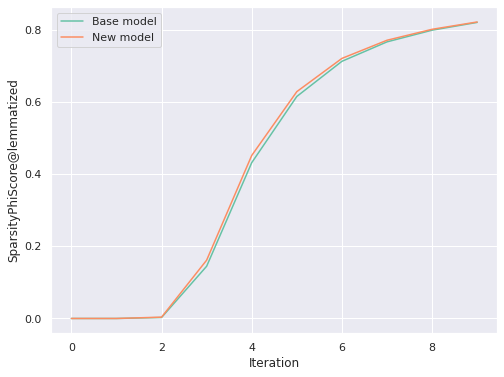

In [86]:
base_models = best_base_model
new_models = best_new_model

plt.figure(figsize=(8, 6))

plt.plot(np.arange(10),
         base_models[0].scores["SparsityPhiScore@lemmatized"],
         label='Base model')
plt.plot(np.arange(10),
         new_models[0].scores["SparsityPhiScore@lemmatized"],
         label='New model')
plt.xlabel('Iteration')
plt.ylabel('SparsityPhiScore@lemmatized')
plt.legend()
plt.show()

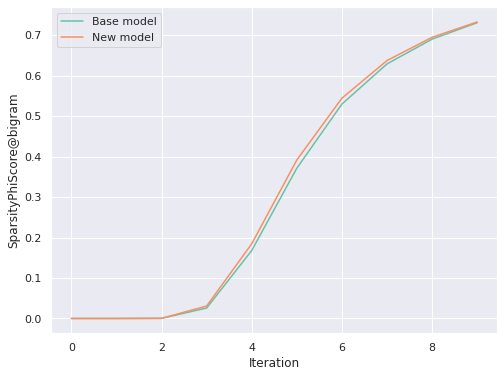

In [87]:
plt.figure(figsize=(8, 6))

plt.plot(np.arange(10), base_models[0].scores["SparsityPhiScore@bigram"], label='Base model')
plt.plot(np.arange(10), new_models[0].scores["SparsityPhiScore@bigram"], label='New model')
plt.xlabel('Iteration')
plt.ylabel('SparsityPhiScore@bigram')
plt.legend()
plt.show()